In [112]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
from itertools import product

import lightgbm as lgb
from tqdm import tqdm_notebook

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [113]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


**Load the data from csv**

In [114]:
item_categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
sales_train = pd.read_csv("sales_train.csv")
sample_submission = pd.read_csv("sample_submission.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

# Exploratory Data analysis

In [115]:
print(sales_train.head())
print(test.head())
print(items.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  

In [116]:
items.head(5)
items.describe()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [117]:
item_categories.head(5)
item_categories.describe()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [118]:
sales_train.head(5)
sales_train.describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [119]:
shops.head(5)
shops.describe()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [120]:
test_temp = test.copy()
test_temp['date_block_num'] = 34
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
test_temp = pd.merge(test_temp, item_category_mapping, how='left', on='item_id')
test_temp = test_temp.drop('ID',axis = 1)
sales_train = sales_train.drop('date', axis = 1)

**Add test data**

In [121]:
sales_train_full = pd.concat([sales_train,test_temp], ignore_index = True)

C:\Users\vgpru\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


**Preprocessing the Data and KFold Mean Encoding**

In [122]:
sales = sales_train_full

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


all_data['item_target_enc'] = np.NaN
all_data['shop_target_enc'] = np.NaN

#Apply Mean encoding with KFolds
kf = KFold(n_splits=5, shuffle=False)
item_id_target_mean = []
for train_index, test_index in kf.split(all_data):
    train,test = all_data.iloc[train_index], all_data.iloc[test_index]
    test['item_target_enc'] = test['item_id'].map(train.groupby('item_id').target.mean())
    all_data.iloc[test_index] = test
item_id_target_mean = []
for train_index, test_index in kf.split(all_data):
    train,test = all_data.iloc[train_index], all_data.iloc[test_index]
    test['shop_target_enc'] = test['shop_id'].map(train.groupby('shop_id').target.mean())
    all_data.iloc[test_index] = test

# Fill NaNs
all_data['item_target_enc'].fillna(0.3343, inplace=True)
all_data['shop_target_enc'].fillna(0.3343, inplace=True)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
#all_data2 = all_data.copy()
del grid, gb 
gc.collect();

C:\Users\vgpru\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\vgpru\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Create Lag features for traininig**

In [123]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

C:\Users\vgpru\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [124]:
to_drop_cols = to_drop_cols + ['item_target_enc_lag_1'] + ['item_target_enc_lag_2'] + ['item_target_enc_lag_3'] + ['item_target_enc_lag_4'] + ['item_target_enc_lag_5'] + ['item_target_enc_lag_12']
to_drop_cols.remove('item_target_enc')
to_drop_cols = to_drop_cols + ['shop_target_enc_lag_1'] + ['shop_target_enc_lag_2'] + ['shop_target_enc_lag_3'] + ['shop_target_enc_lag_4'] + ['shop_target_enc_lag_5'] + ['shop_target_enc_lag_12']
to_drop_cols.remove('shop_target_enc')
to_drop_cols

['target',
 'target_item',
 'target_shop',
 'date_block_num',
 'item_target_enc_lag_1',
 'item_target_enc_lag_2',
 'item_target_enc_lag_3',
 'item_target_enc_lag_4',
 'item_target_enc_lag_5',
 'item_target_enc_lag_12',
 'shop_target_enc_lag_1',
 'shop_target_enc_lag_2',
 'shop_target_enc_lag_3',
 'shop_target_enc_lag_4',
 'shop_target_enc_lag_5',
 'shop_target_enc_lag_12']

**Prepare train test cv split**

In [125]:
dates = all_data['date_block_num']

last_block = dates.max()
#print(last_block)

X_train = all_data.loc[dates < last_block - 1].drop(to_drop_cols, axis=1)
X_cv = all_data.loc[dates ==  last_block - 1].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block - 1, 'target'].values
y_cv = all_data.loc[dates ==  last_block - 1, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

# print(X_train_part.shape)
# print(y_train_part.shape)

# X_train.to_pickle("X_train.pkl")
# X_train_part.to_pickle("X_train_part.pkl")
# X_test.to_pickle("X_test.pkl")

# np.save("y_train.npy", y_train)
# np.save("y_train_part.npy", y_train_part)
# np.save("y_test.npy", y_test)

**LBGM Training code**

In [126]:
def lgbm_train(X_train,y_train,X_test,y_test,num_iter):
    lgb_params = {
                   'feature_fraction': 0.75,
                   'metric': 'rmse',
                   'nthread':1, 
                   'min_data_in_leaf': 2**7, 
                   'bagging_fraction': 0.75, 
                   'learning_rate': 0.06, 
                   'objective': 'mse', 
                   'bagging_seed': 2**7, 
                   'num_leaves': 2**7,
                   'bagging_freq':1,
                   'verbose':0 
                  }

    evals_result = {}
    
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_test, label=y_test)
    model = lgb.train(lgb_params, lgb_train, num_iter,
                      valid_sets=[lgb_train, lgb_valid],
                      evals_result=evals_result,
                      verbose_eval=10)
    return model,evals_result


**Lightbm training with 200 iterations with clipped target values**

In [127]:
y_train_clip = y_train.clip(0,20)

In [128]:
model,evals_result  = lgbm_train(X_train, y_train_clip, X_cv, y_cv, 100)

[10]	training's rmse: 0.981714	valid_1's rmse: 5.27444
[20]	training's rmse: 0.892236	valid_1's rmse: 5.2384
[30]	training's rmse: 0.851387	valid_1's rmse: 5.21973
[40]	training's rmse: 0.830319	valid_1's rmse: 5.20858
[50]	training's rmse: 0.819169	valid_1's rmse: 5.20197
[60]	training's rmse: 0.81117	valid_1's rmse: 5.19838
[70]	training's rmse: 0.804373	valid_1's rmse: 5.19555
[80]	training's rmse: 0.798538	valid_1's rmse: 5.19461
[90]	training's rmse: 0.793958	valid_1's rmse: 5.19279
[100]	training's rmse: 0.790204	valid_1's rmse: 5.19205


**Save the model**

In [129]:
model.save_model('lgbm_model_full_clip20.txt')

In [20]:
# from sklearn.ensemble import RandomForestRegressor
# regr = RandomForestRegressor(n_estimators = 10, verbose = 1)
# regr.fit(X_train, y_train_clip)
# pred_rf = regr.predict(X_cv)

# print('Test RMSE for random forests is %f' % np.sqrt(mean_squared_error(y_cv, pred_rf)))

**Linear Regression model for ensembling**

In [19]:
#linear regression in preparation for ensembling
lr = LinearRegression()

lr.fit(X_train.values, y_train_clip)
pred_lr = lr.predict(X_cv)

print('Test RMSE for linreg is %f' % np.sqrt(mean_squared_error(y_cv, pred_lr)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Test RMSE for linreg is 5.231828


**Predictions on cv and test set**

In [141]:
pred_lgb_cv = model.predict(X_cv)
lr.fit(X_train.values, y_train_clip)
pred_lr_cv = lr.predict(X_cv)
#Clip predictions for ensembling
pred_lr_cv = pred_lr_cv.clip(0,20)
pred_lgb_cv = pred_lgb_cv.clip(0,20)
X_cv_level2 = np.c_[pred_lr_cv, pred_lgb_cv]
np.save("X_cv_level2.npy", X_cv_level2)

In [142]:
pred_lgb_test = model.predict(X_test)
lr.fit(X_train.values, y_train_clip)
pred_lr_test = lr.predict(X_test)
pred_lr_test = pred_lr_test.clip(0,20)
pred_lgb_test = pred_lgb_test.clip(0,20)
X_test_level2 = np.c_[pred_lr_test, pred_lgb_test]
np.save("X_test_level2.npy", X_test_level2)

**First level models training similar to assignment**

In [145]:
#First level predictions for ensembling

dates_train = dates[dates <  last_block - 1]
dates_train_level2 = dates_train[dates_train.isin([28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([28, 29, 30, 31, 32])]

# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

count = 0
# Now fill `X_train_level2` with metafeatures
for cur_block_num in [28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''
    X_train_cur = X_train[dates_train.isin(range(12,cur_block_num))]
    y_train_cur = y_train_clip[dates_train.isin(range(12,cur_block_num))]
    X_test_cur = X_train[dates_train.isin([cur_block_num])]
    lr_temp = LinearRegression()
    lr_temp.fit(X_train_cur.values, y_train_cur)
    pred_lr_temp = lr_temp.predict(X_test_cur.values)
    
    model_temp,_ = lgbm_train(X_train_cur, y_train_cur, X_train_cur, y_train_cur, 200)
    pred_lgb_temp = model_temp.predict(X_test_cur)
    
    for i in range(len(pred_lr_temp)):
        X_train_level2[count+i][0]=pred_lr_temp[i]
        X_train_level2[count+i][1]=pred_lgb_temp[i]
    count+=len(pred_lr_temp)
np.save("X_train_full_level2.npy", X_train_level2)
np.save("y_train_full_level2.npy", y_train_level2)

28
[10]	training's rmse: 1.08358	valid_1's rmse: 1.08358
[20]	training's rmse: 1.00086	valid_1's rmse: 1.00086
[30]	training's rmse: 0.950159	valid_1's rmse: 0.950159
[40]	training's rmse: 0.91737	valid_1's rmse: 0.91737
[50]	training's rmse: 0.895866	valid_1's rmse: 0.895866
[60]	training's rmse: 0.881815	valid_1's rmse: 0.881815
[70]	training's rmse: 0.871556	valid_1's rmse: 0.871556
[80]	training's rmse: 0.863844	valid_1's rmse: 0.863844
[90]	training's rmse: 0.857774	valid_1's rmse: 0.857774
[100]	training's rmse: 0.852633	valid_1's rmse: 0.852633
[110]	training's rmse: 0.848298	valid_1's rmse: 0.848298
[120]	training's rmse: 0.844331	valid_1's rmse: 0.844331
[130]	training's rmse: 0.840536	valid_1's rmse: 0.840536
[140]	training's rmse: 0.837106	valid_1's rmse: 0.837106
[150]	training's rmse: 0.833922	valid_1's rmse: 0.833922
[160]	training's rmse: 0.831191	valid_1's rmse: 0.831191
[170]	training's rmse: 0.828993	valid_1's rmse: 0.828993
[180]	training's rmse: 0.826931	valid_1's r

In [147]:
print('Test RMSE for linreg is %f' % np.sqrt(mean_squared_error(y_cv, pred_lr_cv)))
print('Test RMSE for lgbm is %f' % np.sqrt(mean_squared_error(y_cv, pred_lgb_cv)))

Test RMSE for linreg is 5.247907
Test RMSE for lgbm is 5.193346


**Ensembling with averaging**

In [180]:

#Ensembling with averaging implementation

from sklearn.metrics import r2_score
#X_train_level2[:,0].shape
print(r2_score(y_train_level2.clip(0,20), X_train_level2[:,0]))
print(r2_score(y_train_level2.clip(0,20), X_train_level2[:,1]))
alphas_to_try = np.linspace(0, 1, 1001)
best_r2 = 0.0
best_alpha = -1
for alpha in alphas_to_try:
    curr_r2 = r2_score(y_train_level2.clip(0,20), np.dot(X_train_level2, [alpha,1-alpha]))
    if curr_r2 > best_r2:
        best_r2 = curr_r2
        best_alpha = alpha
# YOUR CODE GOES HERE
best_alpha = best_alpha
r2_train_simple_mix = best_r2

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

0.1638807190308701
0.4273387216055792
Best alpha: 0.000000; Corresponding r2 score on train: 0.427339


**Ensembling with stacking on first level predictions**

In [159]:
#Ensembling with stacking predictions
X_train_level2 = np.load("X_train_full_level2.npy")
y_train_level2 = np.load("y_train_full_level2.npy")


lr.fit(X_train_level2.clip(0,20), y_train_level2.clip(0,20))

cv_preds = lr.predict(X_cv_level2)
rmse_test_stacking = np.sqrt(mean_squared_error(y_cv, cv_preds))

test_preds = lr.predict(X_test_level2)
rmse_test_stacking

5.194295736604871

**Save ensembling output to csv**

In [158]:
#predictions on the test set
merged = test.copy()
merged['item_cnt_month'] = test_preds
merged['item_cnt_month']=merged['item_cnt_month'].clip(lower=0,upper=20)
merged=merged.drop(['shop_id','item_id'],axis=1)
merged['ID']=merged['ID'].astype('int')
merged.to_csv("lightgbm_clipto20_ens_full_l2full.csv",index=False)
print(merged.head)

<bound method NDFrame.head of             ID  item_cnt_month
0            0        0.454706
1            1        0.229680
2            2        0.810350
3            3        0.321987
4            4        1.631143
...        ...             ...
214195  214195        0.138287
214196  214196        0.067720
214197  214197        0.046541
214198  214198        0.043305
214199  214199        0.043210

[214200 rows x 2 columns]>


In [182]:
np.save("X_test.npy", X_test)

**Final submission quick test**

In [132]:
#Code to run to get the submitted result

model_lgb = lgb.Booster(model_file='lgbm_model_full_clip20.txt')

X_test_fin = np.load('X_test.npy')
lgb_pred_test_fin = model_lgb.predict(X_test_fin)
lgb_pred_test_fin = lgb_pred_test_fin.clip(0,20)

test_fin = pd.read_csv("test.csv")
test_fin['item_cnt_month'] = lgb_pred_test_fin
test_fin['item_cnt_month']= test_fin['item_cnt_month'].clip(lower=0,upper=20)
test_fin = test_fin.drop(['shop_id','item_id'],axis=1)
test_fin['ID'] = test_fin['ID'].astype('int')
test_fin.to_csv("final_submission_more_lr_enc.csv",index=False)
print(test_fin.head)

<bound method NDFrame.head of             ID  item_cnt_month
0            0        0.401928
1            1        0.196123
2            2        0.847733
3            3        0.304798
4            4        1.525225
...        ...             ...
214195  214195        0.113655
214196  214196        0.044816
214197  214197        0.023280
214198  214198        0.018627
214199  214199        0.019826

[214200 rows x 2 columns]>


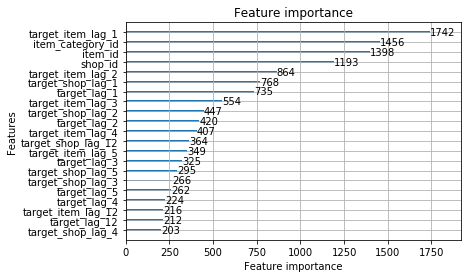

In [111]:
lgb.plot_importance(model_lgb)